In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy import fftpack,signal
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.special import jv
import scipy.signal as sg
import cmath as cm
import alphashape as ap
from scipy import interpolate
from scipy import integrate
import math
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from scipy.interpolate import interp1d, CubicSpline
from matplotlib.colors import Normalize, LogNorm,PowerNorm
from concurrent.futures import ProcessPoolExecutor
from scipy.spatial import ConvexHull, Delaunay
from shapely.geometry import Point
from scipy.optimize import fsolve
from sympy import Derivative
from tqdm import tqdm
import time
import pandas as pd

In [2]:
def Insulator4(m,c,kx,ky,kz,kw,eta):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])

    gamma0 = np.kron(sigmax,np.eye(2))
    gamma1 = np.kron(sigmay,np.eye(2))
    gamma2 = np.kron(sigmaz,sigmax)
    gamma3 = np.kron(sigmaz,sigmay)
    gamma4 = np.kron(sigmaz,sigmaz)

    h4 = m+c*(np.cos(kx)+np.cos(ky)+np.cos(kz)+np.cos(kw))
    h1 = np.sin(kx)
    h2 = np.sin(ky)
    h3 = np.sin(kz)
    h0 = np.sin(kw)+1j*eta
    H = h0*gamma0+h1*gamma1+h2*gamma2+h3*gamma3+h4*gamma4
    return H

def SpinNonEmitianAveTime(m,c,kx,ky,kz,kw,eta,rho0,Time): # 含时演化

    dt = Time[1]-Time[0]
    H = Insulator4(m,c,kx,ky,kz,kw,eta)
    HL = H.T.conjugate()

    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    gamma0 = np.kron(sigmax,np.eye(2))
    gamma1 = np.kron(sigmay,np.eye(2))
    gamma2 = np.kron(sigmaz,sigmax)
    gamma3 = np.kron(sigmaz,sigmay)
    gamma4 = np.kron(sigmaz,sigmaz)


    h4 = m+c*(np.cos(kx)+np.cos(ky)+np.cos(kz)+np.cos(kw))
    h1 = np.sin(kx)
    h2 = np.sin(ky)
    h3 = np.sin(kz)
    h0 = 1j*eta

    E = np.sqrt(h0**2+h1**2+h2**2+h3**2+h4**2)

    U = np.zeros((len(Time),4,4),dtype=complex)
    UL = np.zeros((len(Time),4,4),dtype=complex)

    Spin0 = np.zeros(len(Time),dtype=complex)
    Spin1 = np.zeros(len(Time),dtype=complex)
    Spin2 = np.zeros(len(Time),dtype=complex)
    Spin3 = np.zeros(len(Time),dtype=complex)
    Spin4 = np.zeros(len(Time),dtype=complex)
    state = np.zeros(len(Time),dtype=complex)

    for ti in np.arange(len(Time)):
        U[ti] = expm(-1j*H*Time[ti]) #(np.cos(E*Time[ti])*np.eye(2)-1j*np.sin(E*Time[ti])*H/E)
        UL[ti]= expm(1j*HL*Time[ti]) #(np.cos(EL*Time[ti])*np.eye(2)+1j*np.sin(EL*Time[ti])*HL/EL)
    for i in np.arange(len(Time)):
        Spin0[i]= np.trace(U[i]@rho0@UL[i]@gamma0)/np.trace(U[i]@rho0@UL[i])
        Spin1[i]= np.trace(U[i]@rho0@UL[i]@gamma1)/np.trace(U[i]@rho0@UL[i])
        Spin2[i]= np.trace(U[i]@rho0@UL[i]@gamma2)/np.trace(U[i]@rho0@UL[i])
        Spin3[i]= np.trace(U[i]@rho0@UL[i]@gamma3)/np.trace(U[i]@rho0@UL[i])
        Spin4[i]= np.trace(U[i]@rho0@UL[i]@gamma4)/np.trace(U[i]@rho0@UL[i])
        state[i] = (1-np.cos(2*E*Time[i]))/np.trace(U[i]@rho0@UL[i])
    Spin0Ave = np.sum(Spin0*dt)/Time[-1]
    Spin1Ave = np.sum(Spin1*dt)/Time[-1]
    Spin2Ave = np.sum(Spin2*dt)/Time[-1]
    Spin3Ave = np.sum(Spin3*dt)/Time[-1]
    Spin4Ave = np.sum(Spin4*dt)/Time[-1]
    C = np.sum(state*dt)/Time[-1]
    
    return Spin0Ave,Spin1Ave,Spin2Ave,Spin3Ave,Spin4Ave #,C

In [23]:
m,c = 1,1
eta = 0.2
kx = np.array([-0.1,0.1])
ky = np.arange(-np.pi-np.pi/6,np.pi+np.pi/6+np.pi/3,np.pi/3)
kz = np.arange(-np.pi-np.pi/6,np.pi+np.pi/6+np.pi/3,np.pi/3)
kw= 0
Spin0Ave = np.zeros((len(ky),len(kz)),dtype=complex)
Spin1Ave = np.zeros((len(ky),len(kz)),dtype=complex)
Spin2Ave = np.zeros((len(ky),len(kz)),dtype=complex)
Spin3Ave = np.zeros((len(ky),len(kz)),dtype=complex)
Spin4Ave = np.zeros((len(ky),len(kz)),dtype=complex)
Spin2Ave1 = np.zeros((len(ky),len(kz)),dtype=complex)
Spin3Ave1 = np.zeros((len(ky),len(kz)),dtype=complex)
Spin4Ave1 = np.zeros((len(ky),len(kz)),dtype=complex)
Time = np.linspace(0,200,800)
sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
sigmaz = np.array([[1,0],[0,-1]])
gamma0 = np.kron(sigmax,np.eye(2))
gamma1 = np.kron(sigmay,np.eye(2))
gamma2 = np.kron(sigmaz,sigmax)
gamma3 = np.kron(sigmaz,sigmay)
gamma4 = np.kron(sigmaz,sigmaz)
rho0 = (np.eye(4)-gamma1)/2
for i in np.arange(len(ky)):
    for j in np.arange(len(kz)):
        Spin0Ave[i,j],Spin1Ave[i,j],Spin2Ave[i,j],Spin3Ave[i,j],Spin4Ave[i,j] = SpinNonEmitianAveTime(m,c,kx[0],ky[i],kz[j],kw,eta,rho0,Time)
        Spin0Ave1,Spin1Ave1,Spin2Ave1[i,j],Spin3Ave1[i,j],Spin4Ave1[i,j] = SpinNonEmitianAveTime(m,c,kx[1],ky[i],kz[j],kw,eta,rho0,Time)

In [24]:
G2 = -(Spin2Ave1-Spin2Ave) 
G3 = -(Spin3Ave1-Spin3Ave)
G4 = -(Spin4Ave1-Spin4Ave)


d:\anaconda\lib\site-packages\matplotlib\contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
d:\anaconda\lib\site-packages\matplotlib\contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
d:\anaconda\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


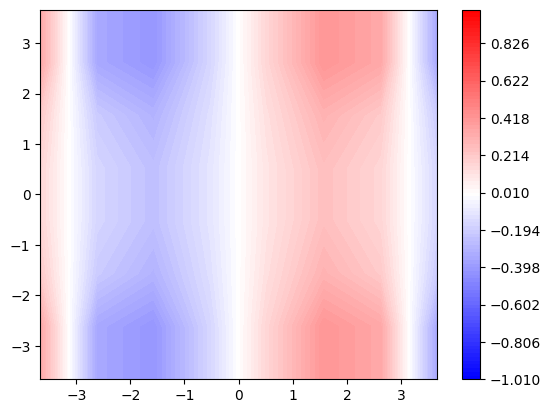

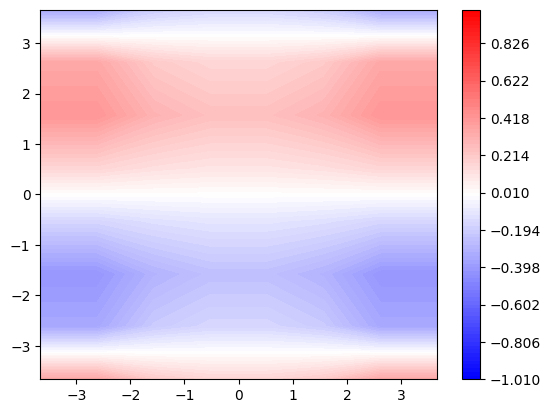

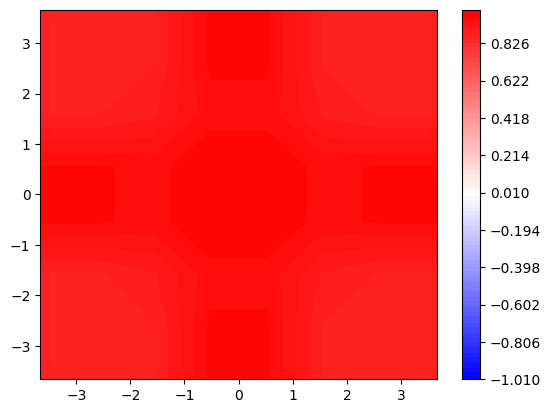

In [25]:
KY,KZ = np.meshgrid(ky,kz,indexing='ij')
fig = plt.figure()
plt.contourf(KY,KZ,G2/np.sqrt(G2**2+G3**2+G4**2),cmap = 'bwr',levels=np.linspace(-1.01,1.01,100))
plt.colorbar()
plt.show()

fig = plt.figure()
plt.contourf(KY,KZ,G3/np.sqrt(G2**2+G3**2+G4**2),cmap = 'bwr',levels=np.linspace(-1.01,1.01,100))
plt.colorbar()
plt.show()

fig = plt.figure()
plt.contourf(KY,KZ,G4/np.sqrt(G2**2+G3**2+G4**2),cmap = 'bwr',levels=np.linspace(-1.01,1.01,100))
plt.colorbar()

In [28]:
data = np.column_stack((KY.ravel(), KZ.ravel(), (G2/np.sqrt(G2**2+G3**2+G4**2)).real.ravel(),(G3/np.sqrt(G2**2+G3**2+G4**2)).real.ravel(),(G4/np.sqrt(G2**2+G3**2+G4**2)).real.ravel()))
df = pd.DataFrame(data, columns=["ky", "kz", "G2", "G3", "G4"])
df.to_csv("Fig_3(a).csv", index=False)